In [1]:
from tqdm import trange
import re
import pickle
import gensim
from gensim import corpora, models
import pandas as pd
import numpy as np
import jieba
import tqdm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import json
from sklearn.decomposition import LatentDirichletAllocation
import copy
import matplotlib.pyplot as plt

In [2]:
def show_topics(vectorizer, lda_model, top_n=20):
    """
    显示每个话题最重要的n个词语
    
    vectorizer: 词袋法或tfidf
    lda_model: 训练好的lda话题模型
    top_n: 设置最重要的n个特征词，默认20.
    """
    import numpy as np
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    #话题-词语权重矩阵
    for topic_weights in lda_model.components_:
        #从大到小排序之后，获得权重最大的top_n词语的位置索引
        top_keyword_locs = (-topic_weights).argsort()[:top_n]
        #在keywords中找到对应的关键词
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [6]:
# 导入数据
with open('data_sh/all_data', 'rb') as f:
    data_sh = pickle.load(f)

with open('data_wh/filter_key_all', 'rb') as f:
    data_wh = pickle.load(f)

In [3]:
data_sh = pd.read_csv('../data_sh/data_sh.csv')
data_wh = pd.read_csv('../data_wh/data_wh.csv')

In [4]:
data_wh['content'] = data_wh['content'].apply(lambda x: re.sub('显示地图', '', x))
data_sh['content'] = data_sh['content'].apply(lambda x: re.sub('显示地图', '', x))

In [5]:
from tqdm import trange
from harvesttext import HarvestText
import pyhanlp
import os
def remove_url(src):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', src, flags=re.MULTILINE)
    return vTEXT

In [6]:
def cl_content(data):
    ht = HarvestText()
    CharTable = pyhanlp.JClass('com.hankcs.hanlp.dictionary.other.CharTable')
    num_null = 0
    cleaned_data = []
    for i in trange(len(data)):
        content = CharTable.convert(str(data.iloc[i]['content'])) #繁转简
        cleaned_content = remove_url(ht.clean_text(content, emoji=False))  # 过滤@后最多6个字符
        cleaned_content = re.sub('#.*?#|《.*?》', '', cleaned_content) # 去除一些词条
        cleaned_data.append(cleaned_content)
        num_null += 1 if cleaned_content == '' else 0
        #print('num data: ', num_null)
    data['cl_content'] = cleaned_data
    return data

In [7]:
data_wh = cl_content(data_wh)

100%|██████████| 38230/38230 [00:07<00:00, 4887.81it/s]


In [8]:
data_sh = cl_content(data_sh)

100%|██████████| 9988/9988 [00:02<00:00, 4211.03it/s]


In [61]:
np.random.seed(1234)
size = len(data_sh) // 5
df_ = data_sh.sample(size)
dt_neg_sh = df_.loc[df_[['pos', 'neg']].apply(lambda row: np.where(row[1]>row[0], True, False).flatten()[0], axis = 1)]
dt_pos_sh = df_.loc[df_[['pos', 'neg']].apply(lambda row: np.where(row[1]<row[0], True, False).flatten()[0], axis = 1)]

In [9]:
ls = ["00", "02", "03", "08", "10", "100", "1000", "11", "120", "13", "14", "15", "17", "18", "19", "20", "200", "2000", "2003", "2008", "2019", "2020", "20200202", "21", "217", "22", "23", "24", "25", "26", "28", "29", "291", "30", "300", "3000", "31", "319", "32", "324", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "440", "45", "46", "47", "48", "49", "50", "500", "5000", "51", "52", "53", "54", "56", "57", "58", "59", "60", "62", "63", "65", "66", "67", "68", "69", "70", "71", "72", "75", "76", "78", "80", "830", "84", "87", "90", "98", "american", "app", "covid", "cry", "ct", "doge", "good", "icu", "n95", "ok", "ps", "sars", "tm", "vlog", "who", "zf", "一下子", "一丝", "一个个", "一个多月", "一个月", "一人", "一件", "一份", "一会", "一会儿", "一位", "一例", "一共", "一刻", "一副", "一半", "一口", "一句", "一只", "一名", "一周", "一味", "一圈", "一场", "一堆", "一声", "一大", "一大早", "一天天", "一套", "一家", "一家人", "一年", "一座", "一张", "一律", "一批", "一把", "一日", "一早", "一是", "一月", "一条", "一次性", "一步", "一段", "一段时间", "一波", "一点点", "一生", "一看", "一眼", "一种", "一篇", "一线", "一群", "一趟", "一路", "一辈子", "一遍", "一部", "一部分","06", "065", "10", "105722", "116", "12320", "13742", "145", "1483", "1588", "18842", "19085", "20", "2021", "2022", "217", "219215", "225281", "243", "327", "3295076", "334801", "3629968", "40421", "4215077", "43775", "44", "5221", "5226", "531", "5543", "57", "58", "588", "61", "618", "63224", "68", "71", "73", "801", "83", "840", "91", "93", "9395", "app", "ip", "lsmgnews", "o2022", "via", "一个月", "一二", "一份", "一位", "一例", "一刀切", "一半", "一周", "一场", "一堆", "一家", "一批", "一日", "一是", "一村", "一波", "一种", "一线", "七宝", "七环", "万人", "三个", "三天", "三次", "上午", "上次", "00", "10", "100", "1000", "11", "13", "14", "15", "17", "18", "19", "20", "200", "2006", "2008", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "21","24", "25", "30", "300", "360", "40", "400", "50", "500", "60", "80", "90", "95","99","go","but", "by", "can","about", "better","do", "don", "for", "from", "have","if", "in","ing","is", "it","just","me", "more", "my","one", "only", "or","that", "the", "think", "this", "time", "to", "too", "we", "what", "when", "who", "will", "with","you","your"] + ["00", "01", "02", "0202", "03", "10", "100", "1000", "11", "11791", "120", "127", "13", "14", "14380", "15", "17", "17205", "18", "19", "20", "200", "2003", "2019", "2020", "20200202", "21", "22", "23", "24", "25", "26", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "45", "46", "47", "48", "49", "50", "500", "51", "53", "56", "60", "65", "70", "72", "74", "75", "7711", "80", "84", "90", "9692", "ace2", "cry", "ct", "doge", "good", "h1n1", "h5n1", "h7n9", "n95", "ncov", "pheic", "ps", "sars", "tm", "vlog", "who", "zf"]
# 加载停止词库
with open('../data/stop_words.txt', 'r', encoding='utf-8') as f:
    stop_words = [i.strip() for i in f.readlines()] + ls

## 使用genism来lda建模

In [47]:
s_ = []
for i in trange(len(split)):
    l = []
    for item in split[i].split():
        if item not in stop_words:
            l.append(item)
    s_.append(l)

100%|██████████| 13923/13923 [00:21<00:00, 662.01it/s]


In [7]:
from collections import defaultdict

In [58]:
texts = s_
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

  0%|          | 0/30 [09:25<?, ?it/s]


In [60]:
texts

[['俊平大', '魔王', '希望', '睡一觉', '明天', '心'],
 ['国内',
  '例',
  '新型',
  '病例',
  '庆幸',
  '去过',
  '去过',
  '感染者',
  '密切接触',
  '病例',
  '二次',
  '传染',
  '传人',
  '特别',
  '厉害',
  '不幸',
  '中',
  '万幸'],
 ['最新消息',
  '年',
  '月',
  '日',
  '时至',
  '时',
  '平遥',
  '新冠',
  '病例',
  '刷新',
  '例',
  '连续',
  '例',
  '🙏',
  '🙏',
  '平遥',
  '稳住',
  '🙏',
  '🙏'],
 ['搅动',
  '全世界',
  '新冠',
  '各国',
  '带来',
  '世卫',
  '组织',
  '幸亏',
  '世界',
  '应对',
  '标杆',
  '式',
  '教案',
  '巴基斯坦',
  '幸亏',
  '意大利',
  '幸亏',
  '美国',
  '幸亏',
  '甩锅',
  '借口'],
 ['恐慌',
  '挡不住',
  '美食',
  '诱惑',
  '㊗',
  '️',
  '平安',
  '输入',
  '性',
  '病例',
  '危机',
  '掉以轻心',
  '生命安全',
  '第一',
  '🙏',
  '🙏',
  '🙏',
  '城'],
 ['早上好', '☀', '世态炎凉', '事', '✨', '🎆', '今日', '立春', '❄', '文案'],
 ['防疫', '情', '几天', '足不出户', '忙', '厨艺', '打发', '时间', '几天', '真该', '减肥'],
 ['结束',
  '希望',
  '强化',
  '强化',
  '野生动物',
  '保护',
  '机制',
  '加大',
  '惩罚',
  '力度',
  '强化',
  '医生',
  '保护',
  '机制',
  '悲伤',
  '天佑',
  '中华'],
 ['昨天',
  '隔离',
  '全家',
  '体温',
  '陪',
  '孩子',
  '写',
  '作业',
  '孩子',
  '拍',
  '防疫',


In [61]:
dictionary = corpora.Dictionary(texts)  # 构建 document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [63]:
ldamodel = Lda(corpus, num_topics=10, id2word = dictionary, passes=50)

In [66]:
Lda = gensim.models.ldamodel.LdaModel
    
def perplexity(num_topics):
    ldamodel = Lda(corpus, num_topics=num_topics, id2word = dictionary, passes=50)  #passes为迭代次数，次数越多越精准
    print(ldamodel.print_topics(num_topics=num_topics, num_words=7))  #num_words为每个主题下的词语数量
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)

# 绘制困惑度折线图
y = [perplexity(i) for i in trange(2, 30)]

[(0, '0.047*"例" + 0.039*"病例" + 0.020*"月" + 0.019*"日" + 0.019*"新型" + 0.018*"新冠" + 0.014*"新增"'), (1, '0.011*"##" + 0.008*"说" + 0.007*"口罩" + 0.007*"病毒" + 0.006*"加油" + 0.006*"希望" + 0.006*"想"')]
-8.461728837750012


KeyboardInterrupt: 

In [ ]:
plt.plot(x, y)
plt.xlabel('主题数目')
plt.ylabel('困惑度大小')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('主题-困惑度变化情况')
plt.show()


## 使用sklearn进行建模

In [10]:
dt = data_wh
dt['cl_content'] = dt['cl_content'].apply(lambda x: re.sub('#.*?#|《.*》?', '', x))

In [11]:
split = []
for idx in trange(len(dt['cl_content'].to_list())):
    content = dt['cl_content'].to_list()[idx]
    tokens = ' '.join(j.strip() for j in jieba.cut(str(content)) if j not in stop_words)
    split.append(tokens)

  0%|          | 0/38230 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.469 seconds.
Prefix dict has been built successfully.
100%|██████████| 38230/38230 [02:01<00:00, 315.94it/s]


In [12]:
s = []
for i in trange(len(split)):
    l = []
    for item in split[i].split():
        if item not in stop_words:
            l.append(item)
    s.append(' '.join(l))


100%|██████████| 38230/38230 [01:00<00:00, 636.47it/s]


In [13]:
vectorizer = CountVectorizer(max_df=0.5, 
                             min_df=20)

doc_term_matrix = vectorizer.fit_transform(split)
doc_term_matrix

<38230x6477 sparse matrix of type '<class 'numpy.int64'>'
	with 655431 stored elements in Compressed Sparse Row format>

In [51]:
from sklearn.decomposition import LatentDirichletAllocation


perplexity = []
for topics in trange(2, 13):
    # Fit LDA to the data 
    LDA = LatentDirichletAllocation(n_components = topics, doc_topic_prior = 0.1, topic_word_prior = 0.1, random_state = 1234)
    news_lda = LDA.fit(doc_term_matrix)
    
    
    perplexity.append(news_lda.perplexity(doc_term_matrix))
 
print(perplexity)

100%|██████████| 11/11 [03:07<00:00, 17.09s/it]

[1269.3338618842652, 1269.6593193416822, 1222.3553104488562, 1231.6788033267962, 1214.9147936513732, 1198.8326538720182, 1223.3705317653514, 1236.280461128872, 1225.0996961995918, 1228.7475160965319, 1216.5086451067873]


<AxesSubplot:xlabel='time'>

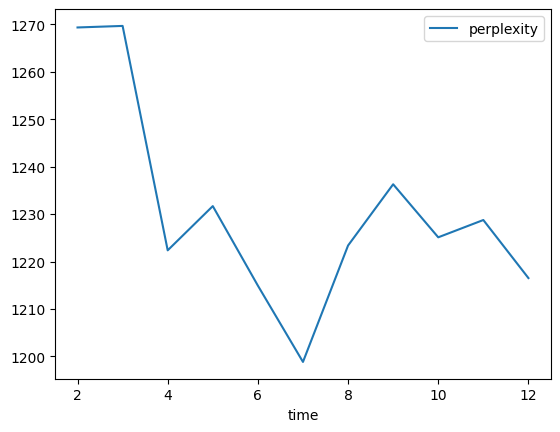

In [52]:
pd.DataFrame({'time': range(2, 13), 'perplexity': perplexity}).plot(x='time', y='perplexity')

In [14]:
best_number = 12

In [66]:
with open('data_sh/best_lda_model_neg', 'rb') as f:
    lda_model = pickle.load(f)
lda_model

LatentDirichletAllocation(doc_topic_prior=0.1, random_state=1234,
                          topic_word_prior=0.1)

In [15]:
LDA = LatentDirichletAllocation(n_components = best_number, doc_topic_prior = 0.1, topic_word_prior = 0.1, random_state=1234)
lda_model = LDA.fit(doc_term_matrix)

In [16]:
prediction = lda_model.fit_transform(doc_term_matrix)

In [17]:
# 向原数据添加标签
dt['topic_label'] = np.argmax(prediction, axis=1)

In [18]:
#可以设置参数的地方
topic_keywords = show_topics(vectorizer= vectorizer,   
                             lda_model = lda_model,     
                             top_n = 20)                 


df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word-'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic-'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word-0,Word-1,Word-2,Word-3,Word-4,Word-5,Word-6,Word-7,Word-8,Word-9,Word-10,Word-11,Word-12,Word-13,Word-14,Word-15,Word-16,Word-17,Word-18,Word-19
Topic-0,加油,英雄,抗疫,感谢,致敬,生命,全国,病毒,城市,医护人员,新冠,牺牲,湖北,抗击,封城,国家,希望,感恩,付出,胜利
Topic-1,医院,隔离,感染,社区,医生,妈妈,病人,情况,检查,发热,发烧,治疗,症状,求助,在家,居家,住院,床位,咳嗽,回家
Topic-2,病毒,新冠,美国,冠状病毒,新型,风险,国家,复工,健康,企业,措施,恢复,全球,经济,感染,时间,工作,影响,指挥部,有序
Topic-3,希望,口罩,封城,平安,家人,朋友,结束,城市,加油,害怕,生活,事情,快点,出门,看着,早日,身边,家里,平平安安,健康
Topic-4,出门,封城,在家,生活,湖北,家里,工作,新闻,加油,消息,感觉,过年,病毒,朋友,上班,解封,不想,地方,希望,时间
Topic-5,病例,新增,死亡,新冠,累计,人数,数据,治愈,感染,感染者,无症状,出院,疑似病例,境外,输入,报告,全国,美国,湖北,患者
Topic-6,封城,在家,家里,妈妈,结束,开心,希望,好好,喜欢,好吃,爸爸,快乐,日子,朋友,出门,生日,加油,时间,蛋糕,解封
Topic-7,解封,封城,希望,终于,结束,城市,春天,期待,热干面,樱花,恢复,阳光,春暖花开,生活,早日,加油,日子,小区,出门,美好
Topic-8,医院,湖北,患者,物资,医护人员,病人,医生,医疗,工作,支援,希望,隔离,新冠,捐赠,加油,新型,护士,湖北省,感谢,感染
Topic-9,小区,社区,感谢,志愿者,团购,物资,爱心,超市,封城,快递,蔬菜,物业,居民,收到,生活,群里,买菜,业主,门口,东西


In [63]:
#可以设置参数的地方
topic_keywords = show_topics(vectorizer= vectorizer,   
                             lda_model = lda_model,     
                             top_n = 20)                 


df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word-'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic-'+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word-0,Word-1,Word-2,Word-3,Word-4,Word-5,Word-6,Word-7,Word-8,Word-9,Word-10,Word-11,Word-12,Word-13,Word-14,Word-15,Word-16,Word-17,Word-18,Word-19
Topic-0,校区,学校,宿舍,解封,上海大学,封校,大学,同学,上海交通大学,宝山,同济大学,希望,老师,闵行校,阿姨,嘉定,好吃,松江,食堂,寝室
Topic-1,隔离,阳性,小区,酒店,医院,居民,方舱,防疫,居委,情况,阴性,街道,电话,居委会,密接,管理,医生,通知,感染,政策
Topic-2,抗原,通知,小区,昨天,志愿者,排队,大白,早上,自测,辛苦,加油,晚上,明天,下楼,下午,足不出户,门口,采样,阴性,大厦
Topic-3,结束,希望,早日,加油,解封,快乐,美好,春天,期待,迪士尼,生活,外滩,抗疫,感谢,生日,乐园,樱花,阳光,日子,博物馆
Topic-4,新冠,无症状,感染者,病例,病毒,新增,感染,居住,管控,发现,患者,人群,复工,营业,隔离,传播,数据,浦东新区,死亡,香港
Topic-5,物资,感谢,志愿者,地区,政府,收到,抗疫,老师,希望,谢谢,感恩,防疫,发放,辛苦,领导,大华,解封,小区,学校,支援
Topic-6,生活,工作,隔离,希望,事情,孩子,时间,回家,居家,感觉,经历,日子,朋友,喜欢,两个,妈妈,好像,情绪,快乐,心情
Topic-7,生活,城市,疫苗,工作,社会,抗疫,国家,病毒,影响,有人,防疫,面对,情绪,社区,理解,老百姓,清零,信息,时间,网络
Topic-8,解封,希望,生活,朋友,自由,封控,世界,结束,两个,日子,家里,小区,早日,城市,不想,恢复,感觉,封城,机会,离开
Topic-9,小区,封控,解封,团购,物资,快递,蔬菜,出门,外卖,静默,超市,居民,街道,大道,东西,团长,居委,家里,收到,在家


In [69]:
stop_list = ['家里', '不行', '两个', '天天','几天','昨天', '早上','新冠', '新型', '感觉', '荣丰', '长城', '右边	', '今日', '头条', '手机']
results = []
for i in range(df_topic_keywords.shape[0]):
    words = df_topic_keywords.iloc[i, ].to_list()
    it = []
    for word in words:
        if word not in stop_list:
            it.append(word)
    item = {}
    item['topic'] = i
    item['key_words'] = ' '.join(it)
    results.append(item)


In [74]:
with open('data_wh/kewwords_neg', 'wb') as f:
    f.write(pickle.dumps(results))

In [81]:
with open('data_sh/kewwords_neg', 'rb') as f:
    results_neg = pickle.load(f)

with open('data_sh/kewwords_pos', 'rb') as f:
    results_pos = pickle.load(f)

In [70]:
results

[{'topic': 0,
  'key_words': '学校 校区 解封 宿舍 老师 同学 上海大学 感谢 封校 希望 大学 学生 宝山 上海交通大学 同济大学 好吃 闵行校 校园 嘉定 松江'},
 {'topic': 1,
  'key_words': '隔离 阳性 小区 酒店 防疫 医院 居民 方舱 情况 居委 街道 管理 工作 政策 阴性 抗疫 志愿者 感染 居委会 密接'},
 {'topic': 2,
  'key_words': '抗原 小区 通知 出门 下午 晚上 排队 下楼 大白 解封 明天 口罩 门口 大道 时间 封控 静默 志愿者'},
 {'topic': 3,
  'key_words': '解封 希望 结束 封控 生活 快乐 早日 日子 美好 春天 开心 喜欢 朋友 终于 隔离 自由 外滩 期待 在家'},
 {'topic': 4,
  'key_words': '无症状 病毒 感染者 病例 恢复 疫苗 新增 居住 感染 清零 管控 发现 新闻 经济 博物馆 浦东 死亡 社会 接种'},
 {'topic': 5,
  'key_words': '物资 小区 团购 地区 解封 感谢 封控 蔬菜 政府 志愿者 收到 东西 邻居 抗疫 外卖 快递 曲阳 迪士尼 发放'},
 {'topic': 6,
  'key_words': '生活 工作 城市 希望 事情 时间 朋友 情绪 经历 居家 隔离 影响 焦虑 努力 世界 日子 喜欢 人生'}]

In [71]:
keywords = [result['key_words'] for result in results]
keywords

['学校 校区 解封 宿舍 老师 同学 上海大学 感谢 封校 希望 大学 学生 宝山 上海交通大学 同济大学 好吃 闵行校 校园 嘉定 松江',
 '隔离 阳性 小区 酒店 防疫 医院 居民 方舱 情况 居委 街道 管理 工作 政策 阴性 抗疫 志愿者 感染 居委会 密接',
 '抗原 小区 通知 出门 下午 晚上 排队 下楼 大白 解封 明天 口罩 门口 大道 时间 封控 静默 志愿者',
 '解封 希望 结束 封控 生活 快乐 早日 日子 美好 春天 开心 喜欢 朋友 终于 隔离 自由 外滩 期待 在家',
 '无症状 病毒 感染者 病例 恢复 疫苗 新增 居住 感染 清零 管控 发现 新闻 经济 博物馆 浦东 死亡 社会 接种',
 '物资 小区 团购 地区 解封 感谢 封控 蔬菜 政府 志愿者 收到 东西 邻居 抗疫 外卖 快递 曲阳 迪士尼 发放',
 '生活 工作 城市 希望 事情 时间 朋友 情绪 经历 居家 隔离 影响 焦虑 努力 世界 日子 喜欢 人生']

In [72]:
dt_ = copy.deepcopy(dt)
dt_['keywords'] = 'None'
for i in range(len(results)):
    dt_['keywords'][dt_['topic_label'] == i] = results[i]['key_words']


/home/lzh/miniconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [73]:
dt_ = dt_.reset_index(drop = True)

In [35]:
# 删去不需要的主题
dt_ = dt_.loc[dt_['topic_label'] != 1]

In [74]:
dt_.reset_index(drop=True).to_csv('../data_sh/dt_lda.csv', index = False)

In [77]:
dt_['topic_label'].value_counts()

3    2364
6    1688
0    1684
5    1486
2    1199
1    1039
4     528
Name: topic_label, dtype: int64